In [13]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.tools.sm_exceptions import ValueWarning
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings('ignore', category=ValueWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from statsmodels.tsa.stattools import adfuller

data = pd.read_csv('finalized_county.csv').iloc[:, 1:]

In [2]:
data.county.unique()

array(['Los Angeles', 'Orange', 'San Diego', 'Miami-Dade', 'Cook',
       'Clark', 'Nassau', 'New York City', 'Suffolk', 'Philadelphia',
       'Harris', 'Tarrant'], dtype=object)

In [3]:
def difference(df):
    df['incremental_cases'] = df['incremental_cases'].diff().fillna(df['incremental_cases'])
    return df

## New York City

In [8]:
nyc = data[data['county'] == 'New York City'].loc[:, ['date', 'incremental_cases']]
nyc['incremental_cases'] = nyc['incremental_cases'].astype('int')
nyc['date'] = pd.to_datetime(nyc['date'], format="%Y-%m-%d")

def stationary_test(series):
    result = adfuller(series)
    return (result[0], result[1])

# NYC data is stationary without any differencing
stationary_test(nyc.incremental_cases)

(-4.025903244951222, 0.001280785627022553)

In [9]:
# use 85%-15% for train-test split
train = nyc.iloc[:230, :]
test = nyc.iloc[230:, :]

In [14]:
p_values = [1, 5, 10]
d_values = [1, 2, 4, 6]
q_values = [1, 5, 10, 15]
vals = []
prev = 100000000000000000000000000
for p in p_values:
    for d in d_values:
        for q in q_values:
            param = (p, d, q)
            model = ARIMA(train.incremental_cases, order=param).fit()
            pred = model.forecast(steps=40)
            mse = mean_squared_error(test.incremental_cases, pred)
            if mse < prev:
                prev = mse
                best = param
            print(mse, 'for parameters', param)
print(best, prev)

1549063.5364596266 for parameters (1, 1, 1)
1041981.0101645675 for parameters (1, 1, 5)
1357956.7566587704 for parameters (1, 1, 10)
1216463.400977837 for parameters (1, 1, 15)
1349629.7010003189 for parameters (1, 2, 1)
795102.808458714 for parameters (1, 2, 5)
451981.9084357934 for parameters (1, 2, 10)
869091.3267274689 for parameters (1, 2, 15)
2266445224.5778875 for parameters (1, 4, 1)
1371308.3356573884 for parameters (1, 4, 5)
1753167.2797663421 for parameters (1, 4, 10)
28119669.887651384 for parameters (1, 4, 15)
1125052446068457.8 for parameters (1, 6, 1)
66635202.362387575 for parameters (1, 6, 5)
471171432.5514668 for parameters (1, 6, 10)
2211714.9718962056 for parameters (1, 6, 15)
1540055.7607299844 for parameters (5, 1, 1)
977904.4150121424 for parameters (5, 1, 5)
1612418.6687248657 for parameters (5, 1, 10)
1160768.1848970563 for parameters (5, 1, 15)
1045601.9788290743 for parameters (5, 2, 1)
276382.93671741756 for parameters (5, 2, 5)
1000460.6182987783 for parame

In [15]:
model = ARIMA(train.incremental_cases, order=(5, 4, 10)).fit()
pred = model.forecast(steps=40)
r2 = r2_score(test.incremental_cases, pred)
r2

0.8294055720342459

In [16]:
p_values = [3, 4, 5, 6]
d_values = [3, 4, 5, 6]
q_values = [9, 10, 11]
vals = []
prev = 100000000000000000000000000
for p in p_values:
    for d in d_values:
        for q in q_values:
            param = (p, d, q)
            model = ARIMA(train.incremental_cases, order=param).fit()
            pred = model.forecast(steps=40)
            mse = mean_squared_error(test.incremental_cases, pred)
            if mse < prev:
                prev = mse
                best = param
            print(mse, 'for parameters', param)
print(best, prev)

1220766.5634239335 for parameters (3, 3, 9)
521290.95808599424 for parameters (3, 3, 10)
511798.3289727288 for parameters (3, 3, 11)
1810401.3788042876 for parameters (3, 4, 9)
250920.37393956244 for parameters (3, 4, 10)
182738.17447471875 for parameters (3, 4, 11)
5453980.512635309 for parameters (3, 5, 9)
35749298.601994716 for parameters (3, 5, 10)
61603678.70280813 for parameters (3, 5, 11)
237410694.15880078 for parameters (3, 6, 9)
247915191.81539136 for parameters (3, 6, 10)
504195.94077514356 for parameters (3, 6, 11)
285356.3330654354 for parameters (4, 3, 9)
881290.5061518478 for parameters (4, 3, 10)
1133130.7506620071 for parameters (4, 3, 11)
296363.70141635626 for parameters (4, 4, 9)
68887.63015841597 for parameters (4, 4, 10)
265524.68658765574 for parameters (4, 4, 11)
21233506.540181123 for parameters (4, 5, 9)
36539271.81010924 for parameters (4, 5, 10)
25427878.32972912 for parameters (4, 5, 11)
77078398.74759933 for parameters (4, 6, 9)
88719710.70621257 for param

In [17]:
model = ARIMA(train.incremental_cases, order=(4, 4, 10)).fit()
pred = model.forecast(steps=40)
r2 = r2_score(test.incremental_cases, pred)
r2

0.8762065966151361

<AxesSubplot:xlabel='date'>

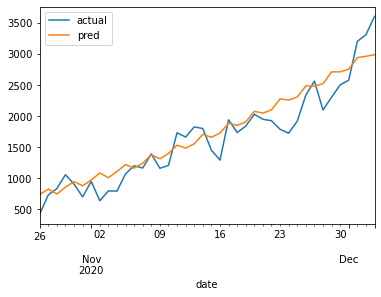

In [18]:
prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True), 
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

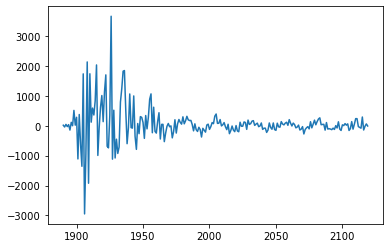

In [19]:
plt.plot(model.resid)

## Suffolk

In [41]:
suffolk = data[data['county'] == 'Suffolk'].loc[:, ['date', 'incremental_cases']]
suffolk['incremental_cases'] = suffolk['incremental_cases'].astype('int')
suffolk['date'] = pd.to_datetime(suffolk['date'], format="%Y-%m-%d")

# suffolk is non-stationary
print(stationary_test(suffolk.incremental_cases))

# get this value for reversion purposes
print(suffolk.loc[suffolk['date'] == '2020-10-25', 'incremental_cases'])

# first-level differencing
suffolk['incremental_cases'] = suffolk['incremental_cases'].diff(
).fillna(suffolk['incremental_cases']).astype('int')

# suffolk is still non-stationary after first-level differencing
stationary_test(suffolk.incremental_cases)

# get this value for reversion purposes
print(suffolk.loc[suffolk['date'] == '2020-10-25', 'incremental_cases'])

# second-level differencing
suffolk['incremental_cases'] = suffolk['incremental_cases'].diff(
).fillna(suffolk['incremental_cases']).astype('int')

# suffolk is stationary after second-level differencing
stationary_test(suffolk.incremental_cases)

(-1.9912096665928523, 0.2904406048537419)
2389    101
Name: incremental_cases, dtype: int64
2389   -62
Name: incremental_cases, dtype: int64


(-14.698522702913342, 2.9719362953173403e-27)

<AxesSubplot:xlabel='date', ylabel='incremental_cases'>

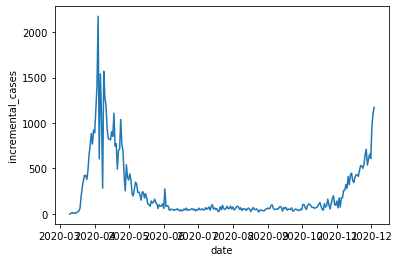

In [66]:
# use differenced cases for train
train = suffolk.iloc[:230, :]

# use non-differenced cases for test actuals
og = data[data['county'] == 'Suffolk'].loc[:, ['date', 'incremental_cases']]
og.incremental_cases = og.incremental_cases.astype('int')
og.date = pd.to_datetime(og.date, format="%Y-%m-%d")
test = og.iloc[230:, :]

sns.lineplot(x="date", y="incremental_cases",legend = 'full' , data=og)

In [34]:
p_values = [1, 5, 10, 15]
d_values = [1, 3, 5]
q_values = [1, 5, 10]
vals = []
prev = 100000000000000000000000000
for p in p_values:
    for d in d_values:
        for q in q_values:
            param = (p, d, q)
            model = ARIMA(train.incremental_cases, order=param).fit()
            pred = model.forecast(steps=40)
            pred = pd.concat([pd.Series([-62]), pred]).cumsum()[1:]
            pred = pd.concat([pd.Series([101]), pred]).cumsum()[1:]
            mse = mean_squared_error(test.incremental_cases, pred)
            if mse < prev:
                prev = mse
                best = param
            print(mse, 'for parameters', param)
print(best, prev)

328756.30299393804 for parameters (1, 1, 1)
95704.77003054768 for parameters (1, 1, 5)
97967.26446041746 for parameters (1, 1, 10)
302370645130.9877 for parameters (1, 3, 1)
1518140.3840154111 for parameters (1, 3, 5)
3559889.6701657968 for parameters (1, 3, 10)
1.115400112932473e+16 for parameters (1, 5, 1)
88469946262.8493 for parameters (1, 5, 5)
17835273161.700294 for parameters (1, 5, 10)
19098.250311920237 for parameters (5, 1, 1)
75352.84278661487 for parameters (5, 1, 5)
164061.80554217723 for parameters (5, 1, 10)
1546271290.0141037 for parameters (5, 3, 1)
658655.3049371885 for parameters (5, 3, 5)
116718.34943748191 for parameters (5, 3, 10)
2793090445882.8857 for parameters (5, 5, 1)
23253781373.04783 for parameters (5, 5, 5)
2130002.660859504 for parameters (5, 5, 10)
76536.7951712968 for parameters (10, 1, 1)
76569.38821303677 for parameters (10, 1, 5)
117874.63483392494 for parameters (10, 1, 10)
49052707.36171587 for parameters (10, 3, 1)
308299.2340914166 for parameter

In [38]:
model = ARIMA(train.incremental_cases, order=(5, 1, 1)).fit()
pred = pd.concat([pd.Series([-62]), model.forecast(steps=40)]).cumsum()[1:]
pred = pd.concat([pd.Series([101]), pred]).cumsum()[1:]
r2 = r2_score(test.incremental_cases, pred)
r2

0.7277560066654538

In [44]:
p_values = [3, 4, 5, 6]
d_values = [0, 1, 2, 3]
q_values = [0, 1, 2, 3]
vals = []
prev = 100000000000000000000000000
for p in p_values:
    for d in d_values:
        for q in q_values:
            param = (p, d, q)
            model = ARIMA(train.incremental_cases, order=param).fit()
            pred = model.forecast(steps=40)
            pred = pd.concat([pd.Series([-62]), pred]).cumsum()[1:]
            pred = pd.concat([pd.Series([101]), pred]).cumsum()[1:]
            mse = mean_squared_error(test.incremental_cases, pred)
            if mse < prev:
                prev = mse
                best = param
            print(mse, 'for parameters', param)
print(best, prev)

26795.576370541276 for parameters (3, 0, 0)
227308.2220268255 for parameters (3, 0, 1)
228419.61577016412 for parameters (3, 0, 2)
227374.34531893424 for parameters (3, 0, 3)
3502610.682856617 for parameters (3, 1, 0)
26818.874407237472 for parameters (3, 1, 1)
231787.03655003692 for parameters (3, 1, 2)
230924.93045679777 for parameters (3, 1, 3)
1225558498.5519795 for parameters (3, 2, 0)
4019184.4249214516 for parameters (3, 2, 1)
15560.872534193735 for parameters (3, 2, 2)
15473.817623478613 for parameters (3, 2, 3)
186243289088.4706 for parameters (3, 3, 0)
1286410846.4326963 for parameters (3, 3, 1)
4801499.388405604 for parameters (3, 3, 2)
10810736.358670453 for parameters (3, 3, 3)
23007.285589432486 for parameters (4, 0, 0)
235415.65983718206 for parameters (4, 0, 1)
74024.34721067201 for parameters (4, 0, 2)
170165.23967269712 for parameters (4, 0, 3)
2295427.446994893 for parameters (4, 1, 0)
23030.22863681036 for parameters (4, 1, 1)
25413.934885017436 for parameters (4, 1

In [45]:
model = ARIMA(train.incremental_cases, order=(6, 2, 2)).fit()
pred = pd.concat([pd.Series([-62]), model.forecast(steps=40)]).cumsum()[1:]
pred = pd.concat([pd.Series([101]), pred]).cumsum()[1:]
r2 = r2_score(test.incremental_cases, pred)
r2

0.7925434238948796

In [50]:
p_values = [5, 6, 7, 8]
d_values = [1, 2, 3]
q_values = [1, 2, 3]
vals = []
prev = 100000000000000000000000000
for p in p_values:
    for d in d_values:
        for q in q_values:
            param = (p, d, q)
            model = ARIMA(train.incremental_cases, order=param).fit()
            pred = model.forecast(steps=40)
            pred = pd.concat([pd.Series([-62]), pred]).cumsum()[1:]
            pred = pd.concat([pd.Series([101]), pred]).cumsum()[1:]
            mse = mean_squared_error(test.incremental_cases, pred)
            if mse < prev:
                prev = mse
                best = param
            print(mse, 'for parameters', param)
print(best, prev)

19098.250311920237 for parameters (5, 1, 1)
125717.48935706072 for parameters (5, 1, 2)
16016.046975004789 for parameters (5, 1, 3)
706272.2993422815 for parameters (5, 2, 1)
2717166.697750178 for parameters (5, 2, 2)
34414.29939074707 for parameters (5, 2, 3)
1546271290.0141037 for parameters (5, 3, 1)
1311182460.416439 for parameters (5, 3, 2)
3251983.1649843855 for parameters (5, 3, 3)
25836.083951161516 for parameters (6, 1, 1)
85384.05686233942 for parameters (6, 1, 2)
125575.03887247402 for parameters (6, 1, 3)
2923334.5302702878 for parameters (6, 2, 1)
14553.33346672136 for parameters (6, 2, 2)
158086.45249621622 for parameters (6, 2, 3)
557662732.043627 for parameters (6, 3, 1)
4137651.2444254137 for parameters (6, 3, 2)
26869.4405721809 for parameters (6, 3, 3)
51983.23312491763 for parameters (7, 1, 1)
80362.65231731646 for parameters (7, 1, 2)
85410.98955250515 for parameters (7, 1, 3)
4277082.5200314615 for parameters (7, 2, 1)
31886.1590722995 for parameters (7, 2, 2)
142

In [51]:
model = ARIMA(train.incremental_cases, order=(6, 2, 2)).fit()
pred = pd.concat([pd.Series([-62]), model.forecast(steps=40)]).cumsum()[1:]
pred = pd.concat([pd.Series([101]), pred]).cumsum()[1:]
r2 = r2_score(test.incremental_cases, pred)
r2

0.7925434238948796

<AxesSubplot:xlabel='date'>

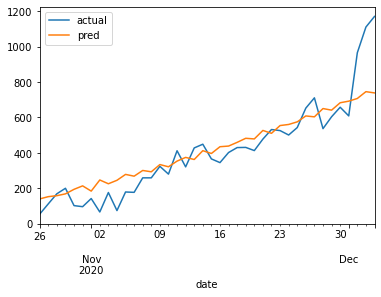

In [52]:
prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True), 
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

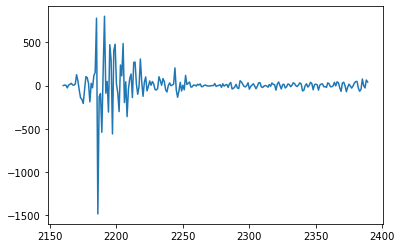

In [53]:
plt.plot(model.resid)

## Clark

In [56]:
clark = data[data['county'] == 'Clark'].loc[:, ['date', 'incremental_cases']]
clark['incremental_cases'] = clark['incremental_cases'].astype('int')
clark['date'] = pd.to_datetime(clark['date'], format="%Y-%m-%d")

# clark is non-stationary
print(stationary_test(clark.incremental_cases))

# get this value for reversion purposes
print(clark.loc[clark['date'] == '2020-10-25', 'incremental_cases'])

# first-level differencing
clark['incremental_cases'] = clark['incremental_cases'].diff(
).fillna(clark['incremental_cases']).astype('int')

# suffolk is stationary after first-level differencing
print(stationary_test(clark.incremental_cases))

(-0.11236379030359485, 0.9481930426302596)
1579    735
Name: incremental_cases, dtype: int64
(-3.3449201000745075, 0.012986122973228372)


<AxesSubplot:xlabel='date', ylabel='incremental_cases'>

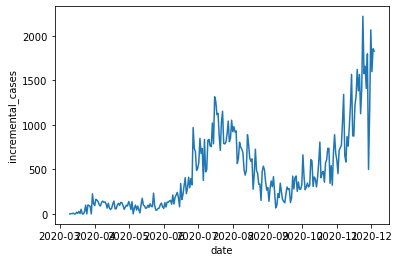

In [65]:
# use differenced cases for train
train = clark.iloc[:230, :]

# use non-differenced cases for test actuals
og = data[data['county'] == 'Clark'].loc[:, ['date', 'incremental_cases']]
og.incremental_cases = og.incremental_cases.astype('int')
og.date = pd.to_datetime(og.date, format="%Y-%m-%d")
test = og.iloc[230:, :]

sns.lineplot(x="date", y="incremental_cases",legend = 'full' , data=og)

In [59]:
p_values = [1, 5, 10, 15]
d_values = [1, 3, 5]
q_values = [1, 5, 10, 15]
vals = []
prev = 100000000000000000000000000
for p in p_values:
    for d in d_values:
        for q in q_values:
            param = (p, d, q)
            model = ARIMA(train.incremental_cases, order=param).fit()
            pred = model.forecast(steps=40)
            pred = pd.concat([pd.Series([735]), pred]).cumsum()[1:]
            mse = mean_squared_error(test.incremental_cases, pred)
            if mse < prev:
                prev = mse
                best = param
            print(mse, 'for parameters', param)
print(best, prev)

316603.60332153714 for parameters (1, 1, 1)
162528.61706663127 for parameters (1, 1, 5)
181925.4691648996 for parameters (1, 1, 10)
220523.65844374863 for parameters (1, 1, 15)
227296375.15759602 for parameters (1, 3, 1)
3331948.371956575 for parameters (1, 3, 5)
4472509.397645781 for parameters (1, 3, 10)
150879.9635053487 for parameters (1, 3, 15)
15774065870504.484 for parameters (1, 5, 1)
140947640.98832536 for parameters (1, 5, 5)
1744496735.194432 for parameters (1, 5, 10)
9742844470.59451 for parameters (1, 5, 15)
398212.7680708927 for parameters (5, 1, 1)
382936.2759271349 for parameters (5, 1, 5)
229785.13301573056 for parameters (5, 1, 10)
445488.3859824274 for parameters (5, 1, 15)
13947266.479226738 for parameters (5, 3, 1)
10733193.51605082 for parameters (5, 3, 5)
121573.70236501885 for parameters (5, 3, 10)
4867377.198999817 for parameters (5, 3, 15)
1327785480516.2222 for parameters (5, 5, 1)
34894721.69323008 for parameters (5, 5, 5)
5190213.449623789 for parameters (5

In [60]:
model = ARIMA(train.incremental_cases, order=(15, 3, 15)).fit()
pred = pd.concat([pd.Series([735]), model.forecast(steps=40)]).cumsum()[1:]
r2 = r2_score(test.incremental_cases, pred)
r2

0.6134282438372292

In [61]:
p_values = [13, 14, 15, 16]
d_values = [2, 3, 4, 5]
q_values = [13, 14, 15, 16]
vals = []
prev = 100000000000000000000000000
for p in p_values:
    for d in d_values:
        for q in q_values:
            param = (p, d, q)
            model = ARIMA(train.incremental_cases, order=param).fit()
            pred = model.forecast(steps=40)
            pred = pd.concat([pd.Series([735]), pred]).cumsum()[1:]
            mse = mean_squared_error(test.incremental_cases, pred)
            if mse < prev:
                prev = mse
                best = param
            print(mse, 'for parameters', param)
print(best, prev)

133053.82549291052 for parameters (13, 2, 13)
173531.79691120106 for parameters (13, 2, 14)
100906.59196489982 for parameters (13, 2, 15)
134512.72450597567 for parameters (13, 2, 16)
266172.27622103045 for parameters (13, 3, 13)
312891.67837983835 for parameters (13, 3, 14)
348810.3878079738 for parameters (13, 3, 15)
133700.5461487655 for parameters (13, 3, 16)
3276409.469659756 for parameters (13, 4, 13)
97942.67035231285 for parameters (13, 4, 14)
418432.0989389625 for parameters (13, 4, 15)
839235.4771309483 for parameters (13, 4, 16)
9324772.061237438 for parameters (13, 5, 13)
32457367.07346313 for parameters (13, 5, 14)
290469853.69511545 for parameters (13, 5, 15)
33214036.004862726 for parameters (13, 5, 16)
106834.6366250769 for parameters (14, 2, 13)
108964.57916061781 for parameters (14, 2, 14)
152229.11622034595 for parameters (14, 2, 15)
167751.11570006557 for parameters (14, 2, 16)
240363.79965473208 for parameters (14, 3, 13)
397921.7172046368 for parameters (14, 3, 14

In [62]:
model = ARIMA(train.incremental_cases, order=(15, 3, 15)).fit()
pred = pd.concat([pd.Series([735]), model.forecast(steps=40)]).cumsum()[1:]
r2 = r2_score(test.incremental_cases, pred)
r2

0.6134282438372292

<AxesSubplot:xlabel='date'>

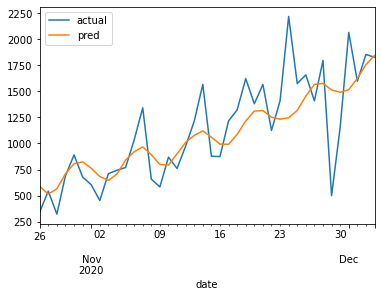

In [63]:
prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True), 
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

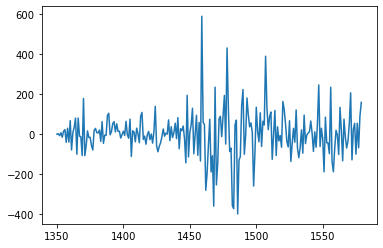

In [64]:
plt.plot(model.resid)

## Nassau

In [136]:
nassau = data[data['county'] == 'Nassau'].loc[:, ['date', 'incremental_cases']]
nassau['incremental_cases'] = nassau['incremental_cases'].astype('int')
nassau['date'] = pd.to_datetime(nassau['date'], format="%Y-%m-%d")
train = nassau.iloc[:230, :]
test = nassau.iloc[230:, :]

<AxesSubplot:xlabel='date', ylabel='incremental_cases'>

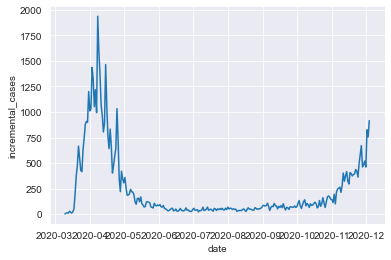

In [33]:
sns.lineplot(x="date", y="incremental_cases",legend = 'full' , data=nassau)

<AxesSubplot:xlabel='date', ylabel='incremental_cases'>

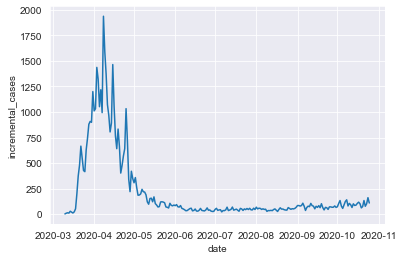

In [30]:
sns.lineplot(x="date", y="incremental_cases",legend = 'full' , data=train)

<AxesSubplot:xlabel='date', ylabel='incremental_cases'>

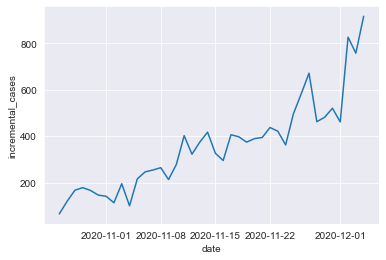

In [31]:
sns.lineplot(x="date", y="incremental_cases",legend = 'full' , data=test)

In [36]:
p_values = [1, 5, 10]
d_values = [1, 2, 4, 6]
q_values = [1, 5, 10, 15]
vals = []
prev = 100000000000000000000000000
for p in p_values:
    for d in d_values:
        for q in q_values:
            param = (p, d, q)
            model = ARIMA(train.incremental_cases, order=param).fit()
            pred = model.forecast(steps=40)
            mse = mean_squared_error(test.incremental_cases, pred)
            if mse < prev:
                prev = mse
                best = param
            print(mse, 'for parameters', param)
print(best, prev)

98302.6115261377 for parameters (1, 1, 1)
93203.25805787843 for parameters (1, 1, 5)
87906.53857891682 for parameters (1, 1, 10)
153414.17805109813 for parameters (1, 1, 15)
90545.12725458835 for parameters (1, 2, 1)
35462.912042247226 for parameters (1, 2, 5)
89574.20511219415 for parameters (1, 2, 10)
87210.82125615045 for parameters (1, 2, 15)
491553382.57529956 for parameters (1, 4, 1)
320672.26478763233 for parameters (1, 4, 5)
7999.098995976927 for parameters (1, 4, 10)
199977.71516906787 for parameters (1, 4, 15)
70100246320125.5 for parameters (1, 6, 1)
41692576.15288268 for parameters (1, 6, 5)
11139859.554922508 for parameters (1, 6, 10)
1884710.5289507066 for parameters (1, 6, 15)
99112.7785867358 for parameters (5, 1, 1)
94352.88733533517 for parameters (5, 1, 5)
81228.31052792163 for parameters (5, 1, 10)
60464.315540533 for parameters (5, 1, 15)
71215.5058525671 for parameters (5, 2, 1)
74454.87024434311 for parameters (5, 2, 5)
87901.45888566402 for parameters (5, 2, 10)

In [52]:
model = ARIMA(train.incremental_cases, order=(1, 4, 10)).fit()
pred = model.forecast(steps=40)
r2 = r2_score(test.incremental_cases, pred)
r2

0.7897425073562174

In [49]:
p_values = [1, 3, 5]
d_values = [2, 3, 4, 5]
q_values = [8, 10, 12]
vals = []
prev = 100000000000000000000000000
for p in p_values:
    for d in d_values:
        for q in q_values:
            param = (p, d, q)
            model = ARIMA(train.incremental_cases, order=param).fit()
            pred = model.forecast(steps=40)
            mse = mean_squared_error(test.incremental_cases, pred)
            if mse < prev:
                prev = mse
                best = param
            print(mse, 'for parameters', param)
print(best, prev)

85174.22031094975 for parameters (1, 2, 8)
89574.20511219415 for parameters (1, 2, 10)
99017.75214948354 for parameters (1, 2, 12)
83749.78158582702 for parameters (1, 3, 8)
131307.23812190793 for parameters (1, 3, 10)
162272.26855612398 for parameters (1, 3, 12)
20088.364275576103 for parameters (1, 4, 8)
7999.098995976927 for parameters (1, 4, 10)
7387.267289115358 for parameters (1, 4, 12)
2882589.210716582 for parameters (1, 5, 8)
63423.80453637923 for parameters (1, 5, 10)
1715081.7497793946 for parameters (1, 5, 12)
80858.94257742283 for parameters (3, 2, 8)
76717.54853112546 for parameters (3, 2, 10)
69806.40551579716 for parameters (3, 2, 12)
25652.148342078654 for parameters (3, 3, 8)
162429.5449254043 for parameters (3, 3, 10)
47185.57015033301 for parameters (3, 3, 12)
50430.71621254432 for parameters (3, 4, 8)
57395.68213365159 for parameters (3, 4, 10)
18072.990139508052 for parameters (3, 4, 12)
55745.17333606801 for parameters (3, 5, 8)
43584.19732261078 for parameters (

In [51]:
model = ARIMA(train.incremental_cases, order=(1, 4, 12)).fit()
pred = model.forecast(steps=40)
r2 = r2_score(test.incremental_cases, pred)
r2

0.8058245936848625

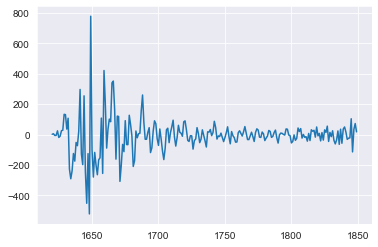

In [138]:
plt.plot(model.resid)

In [53]:
p_values = [1, 2, 3, 4]
d_values = [3, 4, 5, 6]
q_values = [10, 12, 14, 16]
vals = []
prev = 100000000000000000000000000
for p in p_values:
    for d in d_values:
        for q in q_values:
            param = (p, d, q)
            model = ARIMA(train.incremental_cases, order=param).fit()
            pred = model.forecast(steps=40)
            mse = mean_squared_error(test.incremental_cases, pred)
            if mse < prev:
                prev = mse
                best = param
            print(mse, 'for parameters', param)
print(best, prev)

131307.23812190793 for parameters (1, 3, 10)
162272.26855612398 for parameters (1, 3, 12)
6646.556531126199 for parameters (1, 3, 14)
505728.43346036924 for parameters (1, 3, 16)
7999.098995976927 for parameters (1, 4, 10)
7387.267289115358 for parameters (1, 4, 12)
22482.424035708198 for parameters (1, 4, 14)
63108.343840753674 for parameters (1, 4, 16)
63423.80453637923 for parameters (1, 5, 10)
1715081.7497793946 for parameters (1, 5, 12)
2914753.5917041474 for parameters (1, 5, 14)
1616457.9696131092 for parameters (1, 5, 16)
11139859.554922508 for parameters (1, 6, 10)
1441572.691051162 for parameters (1, 6, 12)
744139.1289154652 for parameters (1, 6, 14)
2582647.9816267304 for parameters (1, 6, 16)
55183.20863681255 for parameters (2, 3, 10)
135493.27062885926 for parameters (2, 3, 12)
23153.61373243195 for parameters (2, 3, 14)
43516.22470401444 for parameters (2, 3, 16)
7409.914276551662 for parameters (2, 4, 10)
10352.337507009364 for parameters (2, 4, 12)
101737.86064995872 f

In [137]:
model = ARIMA(train.incremental_cases, order=(1, 3, 14)).fit()
pred = model.forecast(steps=40)
r2 = r2_score(test.incremental_cases, pred)
r2

0.8252942848122512

<AxesSubplot:xlabel='date'>

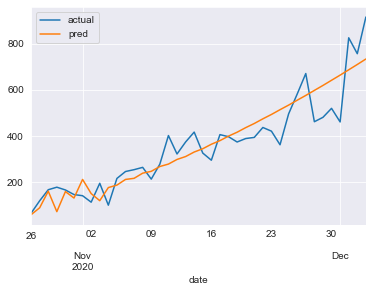

In [73]:
prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True), 
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

In [143]:
cook = data[data['county'] == 'Cook'].loc[:, ['date', 'incremental_cases']]
cook['incremental_cases'] = cook['incremental_cases'].diff().fillna(cook['incremental_cases'])
cook['incremental_cases'] = cook['incremental_cases'].astype('int')
cook['date'] = pd.to_datetime(cook['date'], format="%Y-%m-%d")
train = cook.iloc[:230, :]
test = cook.iloc[230:, :]
og = data[data['county'] == 'Cook'].loc[:, ['date', 'incremental_cases']]
og['incremental_cases'] = og['incremental_cases'].astype('int')
og_test = og.iloc[230:, :]




In [109]:
og.loc[og['date'] == '2020-10-25']

,date,incremental_cases
1309,2020-10-25,1769.0


In [ ]:
prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True), 
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

<AxesSubplot:xlabel='date', ylabel='incremental_cases'>

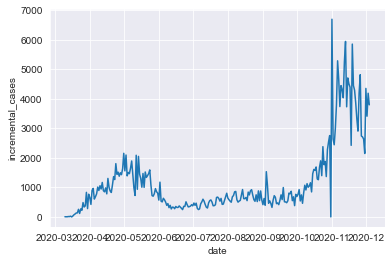

In [115]:
og['incremental_cases'] = og['incremental_cases'].astype('int')
og['date'] = pd.to_datetime(og['date'], format="%Y-%m-%d")
sns.lineplot(x="date", y="incremental_cases",legend = 'full' , data=og)

In [118]:
p_values = [1, 5, 10]
d_values = [1, 3, 5, 7]
q_values = [1, 5, 10, 15]
vals = []
prev = 100000000000000000000000000
for p in p_values:
    for d in d_values:
        for q in q_values:
            param = (p, d, q)
            model = ARIMA(train.incremental_cases, order=param).fit()
            pred = model.forecast(steps=40)
            pred = pd.concat([pd.Series([1769]), pred]).cumsum()[1:]
            mse = mean_squared_error(og_test.incremental_cases, pred)
            if mse < prev:
                prev = mse
                best = param
            print(mse, 'for parameters', param)
print(best, prev)

3922783.4819415575 for parameters (1, 1, 1)
2118428.0805857955 for parameters (1, 1, 5)
2129378.0274179135 for parameters (1, 1, 10)
2187058.3990931353 for parameters (1, 1, 15)
6568291218.025919 for parameters (1, 3, 1)
8370719.979212103 for parameters (1, 3, 5)
2212465.3659426356 for parameters (1, 3, 10)
3805746.048269232 for parameters (1, 3, 15)
5946674890380321.0 for parameters (1, 5, 1)
950417330.4240506 for parameters (1, 5, 5)
11859807759263.777 for parameters (1, 5, 10)
2660885297.4589567 for parameters (1, 5, 15)
2.05140373120688e+20 for parameters (1, 7, 1)
777204930238736.6 for parameters (1, 7, 5)
143794962445.84512 for parameters (1, 7, 10)
620512326062912.4 for parameters (1, 7, 15)
2241922.57920627 for parameters (5, 1, 1)
2356994.1312001413 for parameters (5, 1, 5)
2708044.7053099712 for parameters (5, 1, 10)
2115148.6120981188 for parameters (5, 1, 15)
1469719.156803852 for parameters (5, 3, 1)
6806660.488339471 for parameters (5, 3, 5)
5678876.665218426 for paramete

In [145]:
model = ARIMA(train.incremental_cases, order=(5, 3, 1)).fit()
pred = pd.concat([pd.Series([1769]), model.forecast(steps=40)]).cumsum()[1:]
r2 = r2_score(og_test.incremental_cases, pred)

In [146]:
r2

0.14330023389991453

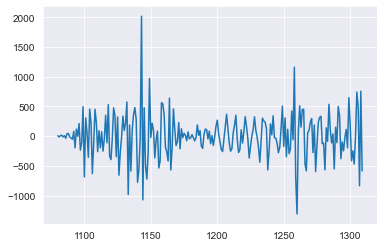

In [135]:
plt.plot(model.resid)

<AxesSubplot:xlabel='date'>

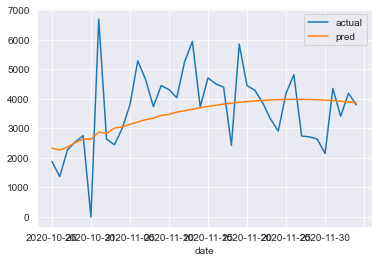

In [141]:
prediction = pd.DataFrame({'actual':og_test.incremental_cases.reset_index(drop = True), 
              'pred':pred.reset_index(drop = True)})
prediction['date'] = og_test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

In [132]:
p_values = [4, 5, 6, 7]
d_values = [1, 2, 3, 4, 5]
q_values = [0, 1, 3, 5, 7]
vals = []
prev = 100000000000000000000000000
for p in p_values:
    for d in d_values:
        for q in q_values:
            param = (p, d, q)
            model = ARIMA(train.incremental_cases, order=param).fit()
            pred = model.forecast(steps=40)
            pred = pd.concat([pd.Series([1769]), pred]).cumsum()[1:]
            mse = mean_squared_error(og_test.incremental_cases, pred)
            if mse < prev:
                prev = mse
                best = param
            print(mse, 'for parameters', param)
print(best, prev)

2585999.181176463 for parameters (4, 1, 0)
4179358.907989816 for parameters (4, 1, 1)
4086561.9613037533 for parameters (4, 1, 3)
2231251.8113776944 for parameters (4, 1, 5)
2082426.2392703951 for parameters (4, 1, 7)
234215625.1595261 for parameters (4, 2, 0)
2952942.64619421 for parameters (4, 2, 1)
2198121.1208846616 for parameters (4, 2, 3)
4343375.152592564 for parameters (4, 2, 5)
2089898.932992354 for parameters (4, 2, 7)
121568655458.96272 for parameters (4, 3, 0)
259899876.88886136 for parameters (4, 3, 1)
16553014.005352518 for parameters (4, 3, 3)
5968901.542837031 for parameters (4, 3, 5)
5011651.435436076 for parameters (4, 3, 7)
2273587935233.435 for parameters (4, 4, 0)
131947786121.81181 for parameters (4, 4, 1)
703604465.555926 for parameters (4, 4, 3)
3440763.1200728393 for parameters (4, 4, 5)
11022276.834254649 for parameters (4, 4, 7)
1998066579776.8625 for parameters (4, 5, 0)
2415284763594.899 for parameters (4, 5, 1)
7790109782.572955 for parameters (4, 5, 3)
90

In [122]:
p_values = [3, 4, 5, 6]
d_values = [1, 3, 5]
q_values = [1, 5, 10, 15]
vals = []
prev = 100000000000000000000000000
for p in p_values:
    for d in d_values:
        for q in q_values:
            param = (p, d, q)
            model = ARIMA(train.incremental_cases, order=param).fit()
            pred = model.forecast(steps=40)
            pred = pd.concat([pd.Series([1769]), pred]).cumsum()[1:]
            mse = mean_squared_error(og_test.incremental_cases, pred)
            if mse < prev:
                prev = mse
                best = param
            print(mse, 'for parameters', param)
print(best, prev)

4067052.1682629855 for parameters (3, 1, 1)
2521412.4214350707 for parameters (3, 1, 5)
2667099.740887978 for parameters (3, 1, 10)
2166698.5632880973 for parameters (3, 1, 15)
345976934.32335967 for parameters (3, 3, 1)
4030257.942905154 for parameters (3, 3, 5)
3291904.391260854 for parameters (3, 3, 10)
5163380.657103458 for parameters (3, 3, 15)
5908246294.270546 for parameters (3, 5, 1)
163909233182.956 for parameters (3, 5, 5)
30707127.064725954 for parameters (3, 5, 10)
16888345.05181956 for parameters (3, 5, 15)
4179358.907989816 for parameters (4, 1, 1)
2231251.8113776944 for parameters (4, 1, 5)
2907226.92483992 for parameters (4, 1, 10)
2163920.4718441474 for parameters (4, 1, 15)
259899876.88886136 for parameters (4, 3, 1)
5968901.542837031 for parameters (4, 3, 5)
8453521.976725897 for parameters (4, 3, 10)
6762148.474988081 for parameters (4, 3, 15)
2415284763594.899 for parameters (4, 5, 1)
9072193896.465366 for parameters (4, 5, 5)
40333014.50572058 for parameters (4, 5